In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats("svg")
from imageio.v2 import imread

In [2]:
Ts = T.Compose([T.ToTensor(), torch.flatten])
mnist_train = torchvision.datasets.MNIST("../data", download=True, transform=Ts)
mnist_test = torchvision.datasets.MNIST("../data", download=True, train=False, transform=Ts)

In [3]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [4]:
mnist_train[0][0].shape

torch.Size([784])

In [5]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [6]:
data = torch.tensor(np.array([x[0] for x in mnist_train]), device=device, dtype=torch.float)
batch_size = 100

In [7]:
data.shape

torch.Size([60000, 784])

In [19]:
class DiscriminatorNet(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 256)
        self.out = nn.Linear(256, 1)
    def forward(self, x):
        x = torch.nn.functional.leaky_relu(self.fc1(x))
        x = torch.nn.functional.leaky_relu(self.fc2(x))
        x = self.out(x)
        return torch.sigmoid(x)
    
dnet = DiscriminatorNet()
dnet.to(device=device)

DiscriminatorNet(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=1, bias=True)
)

In [20]:
x = data[:5]
y = dnet(x)
y.shape, y

(torch.Size([5, 1]),
 tensor([[0.4890],
         [0.4843],
         [0.4930],
         [0.4909],
         [0.4966]], device='cuda:0', grad_fn=<SigmoidBackward0>))

In [21]:
summary(dnet, (784,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
            Linear-2                  [-1, 256]          65,792
            Linear-3                    [-1, 1]             257
Total params: 267,009
Trainable params: 267,009
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 1.02
Estimated Total Size (MB): 1.03
----------------------------------------------------------------


In [22]:
class GeneratorNet(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.fc1 = nn.Linear(64, 256)
        self.fc2 = nn.Linear(256, 256)
        self.out = nn.Linear(256, 28*28)
    def forward(self, x):
        x = torch.nn.functional.leaky_relu(self.fc1(x))
        x = torch.nn.functional.leaky_relu(self.fc2(x))
        x = torch.tanh(self.out(x))
        return x
    
gnet = GeneratorNet()
gnet.to(device=device)

GeneratorNet(
  (fc1): Linear(in_features=64, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=784, bias=True)
)

In [23]:
y = gnet(torch.randn(10, 64, device=device))

In [24]:
summary(gnet, (64,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]          16,640
            Linear-2                  [-1, 256]          65,792
            Linear-3                  [-1, 784]         201,488
Total params: 283,920
Trainable params: 283,920
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.08
Estimated Total Size (MB): 1.09
----------------------------------------------------------------


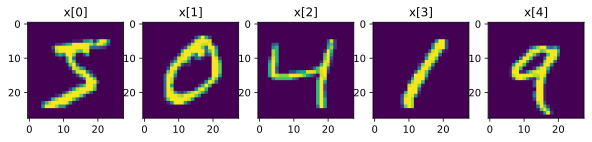

In [25]:
fig, axs = plt.subplots(1, 5, figsize=(10, 5))
ax = axs.flatten()
for i in range(5):
    ax[i].imshow(data[i,:].cpu().squeeze().numpy().reshape((28, 28)))
    ax[i].set_title(f"x[{i}]")
plt.show()

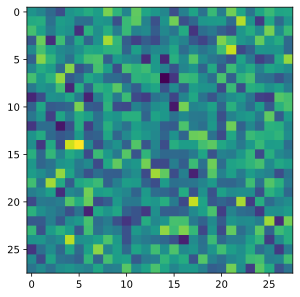

In [26]:
plt.imshow(y[0,:].cpu().detach().reshape((28, 28)))
plt.show()

In [27]:
dnet = DiscriminatorNet().to(device=device)
gnet = GeneratorNet().to(device=device)
lossfunc = nn.BCELoss()
d_optimizer = torch.optim.Adam(dnet.parameters(), lr=.0003)
g_optimizer = torch.optim.Adam(gnet.parameters(), lr=.0003)

epochs = 50_000
losses = np.zeros((epochs, 2))
discriminator_decisions = np.zeros((epochs, 2))

for ei in range(epochs):
    rand_indexes = torch.randint(data.shape[0] ,(batch_size,))

    img_real = data[rand_indexes,:]
    img_fake = gnet(torch.randn(batch_size, 64, device=device))

    labels_real = torch.ones(batch_size, 1, device=device)
    labels_fake = torch.zeros(batch_size, 1, device=device)

    # Train the discriminator
    y_pred_real = dnet(img_real)
    y_pred_fake = dnet(img_fake)
    
    loss_real = lossfunc(y_pred_real, labels_real)
    loss_fake = lossfunc(y_pred_fake, labels_fake)
    d_loss = loss_real + loss_fake
    losses[ei,0] = d_loss.item()
    discriminator_decisions[ei, 0] = torch.mean((y_pred_real>.5).float()).detach()
    
    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    # Train the Generator
    img_fake = gnet(torch.randn(batch_size, 64, device=device))
    pred_fake = dnet(img_fake)
    g_loss = lossfunc(pred_fake, labels_real)
    losses[ei, 1] = g_loss.item()
    discriminator_decisions[ei, 1] = torch.mean((pred_fake>.5).float()).detach()
    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    if ei%500==0:
        print(f"Epoch {ei+1}/{epochs} : d_loss->{d_loss.item():.2f} g_loss->{g_loss.item():.2f}")
        # import sys
        # sys.stdout.write("\r" + f"Epoch {ei+1}/{epochs} : d_loss->{d_loss.item():.2f} g_loss->{g_loss.item():.2f}")

Epoch 1/50000 : d_loss->1.39 g_loss->0.71
Epoch 501/50000 : d_loss->1.64 g_loss->2.04
Epoch 1001/50000 : d_loss->0.44 g_loss->2.46
Epoch 1501/50000 : d_loss->0.43 g_loss->2.98
Epoch 2001/50000 : d_loss->0.45 g_loss->3.41
Epoch 2501/50000 : d_loss->0.44 g_loss->3.21
Epoch 3001/50000 : d_loss->0.31 g_loss->3.79
Epoch 3501/50000 : d_loss->0.19 g_loss->4.06
Epoch 4001/50000 : d_loss->0.15 g_loss->3.88
Epoch 4501/50000 : d_loss->0.26 g_loss->5.29
Epoch 5001/50000 : d_loss->0.10 g_loss->5.72
Epoch 5501/50000 : d_loss->0.16 g_loss->4.88
Epoch 6001/50000 : d_loss->0.28 g_loss->4.45
Epoch 6501/50000 : d_loss->0.22 g_loss->5.30
Epoch 7001/50000 : d_loss->0.15 g_loss->5.98
Epoch 7501/50000 : d_loss->0.18 g_loss->4.47
Epoch 8001/50000 : d_loss->0.18 g_loss->5.15
Epoch 8501/50000 : d_loss->0.08 g_loss->6.67
Epoch 9001/50000 : d_loss->0.12 g_loss->5.44
Epoch 9501/50000 : d_loss->0.19 g_loss->4.17
Epoch 10001/50000 : d_loss->0.18 g_loss->5.81
Epoch 10501/50000 : d_loss->0.19 g_loss->4.70
Epoch 11001/

In [28]:
fig,ax = plt.subplots(1,3,figsize=(18,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend(['Discrimator','Generator'])
# ax[0].set_xlim([4000,5000])

ax[1].plot(losses[::5,0],losses[::5,1],'k.',alpha=.1)
ax[1].set_xlabel('Discriminator loss')
ax[1].set_ylabel('Generator loss')

ax[2].plot(discriminator_decisions)
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Probablity ("real")')
ax[2].set_title('Discriminator output')
ax[2].legend(['Real','Fake'])

plt.show()

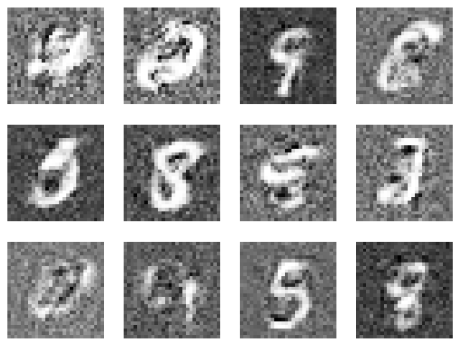

In [29]:
# generate the images from the generator network
gnet.eval()
fake_data = gnet(torch.randn(12,64).to(device)).cpu()

# and visualize...
fig,axs = plt.subplots(3,4,figsize=(8,6))
for i,ax in enumerate(axs.flatten()):
  ax.imshow(fake_data[i,:,].detach().view(28,28),cmap='gray')
  ax.axis('off')

plt.show()